In [1]:
import json
import os
from os import path as osp
import pandas as pd
import numpy as np
from PIL import Image
import re

In [2]:
split = 'dev'

# download annotations from here and put them in nlxgpt/data :
# https://drive.google.com/drive/folders/16sJjeEQE2o23G-GGUi870ubXzJjdRDua
# (cf. nlxgpt/README.md -> Annotations Download -> VQA-X link)

ann_dir = osp.abspath('../data/')
sample_dir = osp.abspath('../generated/')
img_dir = 'PATH'  # insert path to CLEVR images here (CLEVR_v1.0/images/)

# Preparation

## Read Annotations

In [3]:
def load_json(file): 
    with open(file, 'r') as f:
        data = json.load(f)
    return data

def get_confident_answers(list_of_answers): 
    return [x for x in list_of_answers if x['answer_confidence'] == 'yes']

def majority_vote(list_of_answers):
    answers = [a['answer'] for a in list_of_answers]
    return max(set(answers), key=answers.count)

In [4]:
with open(osp.join(ann_dir, f'CLEVRX_{split}.json')) as f:
    annotations = pd.DataFrame(json.load(f)['questions']).set_index('question_index')

## Read & Prepare Samples

In [5]:
def process_sample_file(filename):
    samples_df = pd.read_json(filename)
    
    # rename question id column & set as index
    samples_df = samples_df.rename(columns={'image_id': 'question_id'}).set_index('question_id')

    # split answers from predictions (and collect idx of entries where this doesn't work)
    samples_df['answers_explanations'] = samples_df.caption.map(lambda x: x.split(' because '))
    invalid_ids = samples_df[samples_df.answers_explanations.map(len) != 2].index
    # restrict to valid samples
    samples_df = samples_df[np.logical_not(samples_df.index.isin(invalid_ids))]

    # separate columns for answers and explanations
    samples_df['answer'] = samples_df.answers_explanations.map(lambda x: x[0])
    samples_df['explanation'] = samples_df.answers_explanations.map(lambda x: x[1])
    samples_df = samples_df.drop(columns=['answers_explanations'])
    
    return samples_df, invalid_ids.to_list()

def is_correct_answer(entry, annotations):
    answer = entry.answer
    question_id = entry.name
    # return true if predicted answer matches the annotation
    return answer == annotations.loc[question_id].answer

In [6]:
sample_fname = 'clevrx_unf_captions_full_2_val.json'
sample_file = osp.join(sample_dir, sample_fname)
samples_df, invalid_ids = process_sample_file(sample_file)

In [7]:
# determine correctness of predicted answers
samples_df['correct_answer'] = samples_df.apply(lambda x: is_correct_answer(x, annotations), axis=1)
print('clr acc:', round(sum(samples_df.correct_answer) / len(samples_df), 2))

clr acc: 0.83


# show examples

In [8]:
_anns = annotations.rename(columns={'answer': 'ann_answer', 'factual_explanation': 'ann_explanations'})[['question', 'image_filename', 'image_index', 'ann_answer', 'ann_explanations']]

examples = pd.merge(
    samples_df,
    _anns,
    left_index=True,
    right_index=True
)


In [9]:
def show_example(entry, base_img_dir=img_dir):
    img_fname = entry.image_filename
    split = re.search(r'CLEVR_([a-z]+)_\d+.png', img_fname).group(1)
    img_path = osp.join(base_img_dir, split, img_fname)

    print(f'Q {entry.name} / Image {entry.image_index} / {entry.image_filename}\n')
    
    display(Image.open(img_path))    
    
    # print entries
    print(entry.question, '\n')
    
    print('Predictions:')
    for c in ['answer', 'explanation', 'correct_answer']:
        print(f'\t{c.ljust(15)}\t{entry[c]}')
    print('\n')
    
    print(f'Ann.Answer\t{entry["ann_answer"]}')
    for i, exp in enumerate(entry["ann_explanations"]):
        print(f'Explanation {i+1}\t{exp}')
    
    print(f'\n{"="*25}\n')

Q 296937 / Image 29694 / CLEVR_train_029694.png



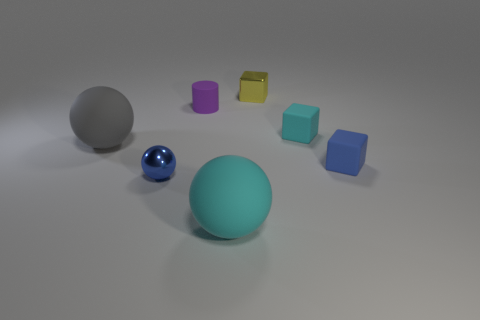

Is the blue thing right of the cylinder made of the same material as the tiny blue object to the left of the metallic block? 

Predictions:
	answer         	no
	explanation    	the blue cube right of the cylinder is rubber and the tiny blue sphere left of the metallic
	correct_answer 	True


Ann.Answer	no
Explanation 1	The blue block to the right of the cylinder is matte and the tiny blue ball to the left of the metallic block is metallic.
Explanation 2	The blue cube right of the cylinder is matte and the tiny blue sphere left of the metallic block is metallic.
Explanation 3	There is a blue matte block which is on the right side of the cylinder and there is a tiny blue metallic ball which is to the left of the metallic block.
Explanation 4	There is a blue matte block which is on the right side of the cylinder and there is a tiny blue shiny sphere that is to the left of the metallic block.
Explanation 5	The blue block on the right side of the cylinder is matte and the tiny blue ball on 

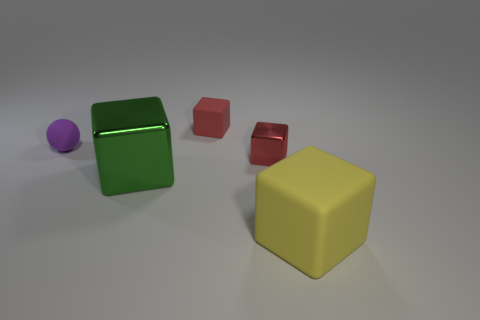

What is the shape of the red thing behind the tiny shiny block in front of the small rubber object that is in front of the tiny rubber cube? 

Predictions:
	answer         	cube
	explanation    	there is a red cube that is behind the tiny shiny block that is in front of the
	correct_answer 	True


Ann.Answer	cube
Explanation 1	There is a red block which is behind the tiny shiny block that is in front of the small rubber sphere that is in front of the tiny rubber cube.
Explanation 2	There is a red cube that is behind the tiny shiny block that is in front of the small rubber sphere that is in front of the tiny rubber cube.


Q 90650 / Image 9065 / CLEVR_train_009065.png



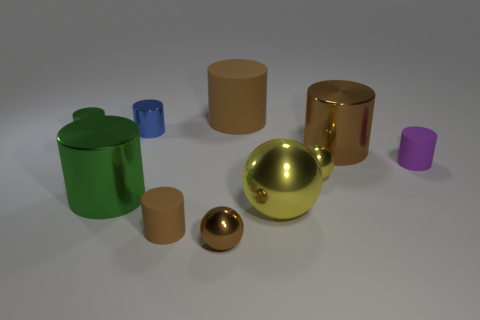

What color is the small object that is both behind the small yellow metal sphere and on the right side of the large shiny ball? 

Predictions:
	answer         	purple
	explanation    	there is a small purple cylinder behind the small yellow metal sphere and to the right of the
	correct_answer 	True


Ann.Answer	purple
Explanation 1	There is a small purple cylinder behind the small yellow metal sphere and right of the large shiny ball.
Explanation 2	There is a small purple cylinder behind the small yellow metal sphere and to the right of the large shiny ball.
Explanation 3	There is a small purple cylinder behind the small yellow metal sphere and on the right side of the large shiny ball.


Q 372109 / Image 37212 / CLEVR_train_037212.png



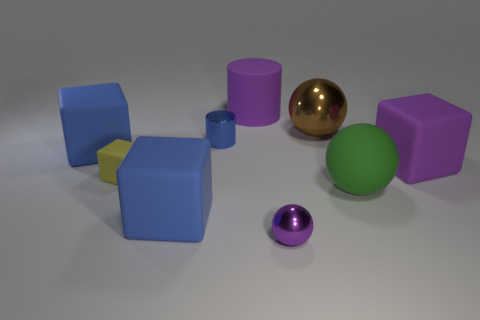

Do the tiny cylinder and the rubber cube that is behind the large purple cube have the same color? 

Predictions:
	answer         	no
	explanation    	the tiny cylinder is blue and the rubber cube behind the large purple cube is purple
	correct_answer 	False


Ann.Answer	yes
Explanation 1	There is a tiny blue cylinder and there is a blue rubber cube which is behind the large purple cube.
Explanation 2	There is a tiny blue cylinder and there is a blue rubber cube that is behind the large purple cube.
Explanation 3	The tiny cylinder is blue and the rubber cube behind the large purple cube is blue.


Q 473317 / Image 47332 / CLEVR_train_047332.png



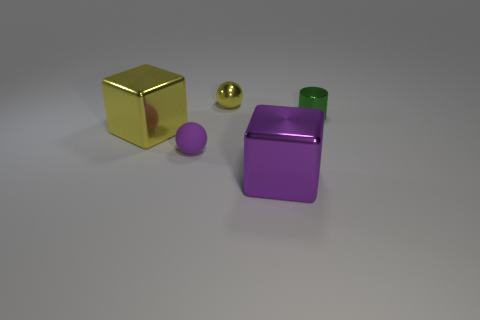

There is a yellow object behind the big metal cube behind the large purple metallic block in front of the small green cylinder; what is its size? 

Predictions:
	answer         	small
	explanation    	there is a tiny yellow sphere that is behind the big metal cube that is behind the large
	correct_answer 	True


Ann.Answer	small
Explanation 1	There is a small yellow ball which is behind the big metal cube that is behind the large purple metallic block that is in front of the small green cylinder.
Explanation 2	There is a small yellow sphere that is behind the big metal cube that is behind the large purple metallic block that is in front of the small green cylinder.
Explanation 3	There is a tiny yellow ball which is behind the big metal cube that is behind the large purple metallic block that is in front of the small green cylinder.
Explanation 4	There is a tiny yellow sphere that is behind the big metal cube that is behind the large purple metallic block that is in front of the small g

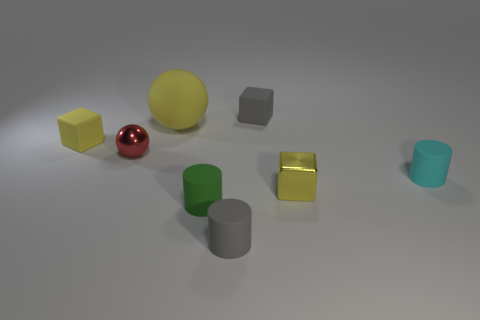

Is the yellow sphere that is behind the tiny cyan rubber cylinder made of the same material as the yellow block in front of the red metal thing? 

Predictions:
	answer         	no
	explanation    	there is a yellow matte sphere that is behind the tiny cyan rubber cylinder and there is a
	correct_answer 	True


Ann.Answer	no
Explanation 1	There is a yellow rubber sphere which is behind the tiny cyan rubber cylinder and there is a yellow shiny block which is in front of the red metal sphere.
Explanation 2	The yellow sphere behind the tiny cyan rubber cylinder is rubber and the yellow block in front of the red metal sphere is metallic.
Explanation 3	The yellow sphere behind the tiny cyan rubber cylinder is rubber and the yellow block in front of the red metal sphere is metal.
Explanation 4	There is a yellow matte sphere that is behind the tiny cyan rubber cylinder and there is a yellow metal block that is in front of the red metal sphere.
Explanation 5	The yellow sphere behind the tiny cy

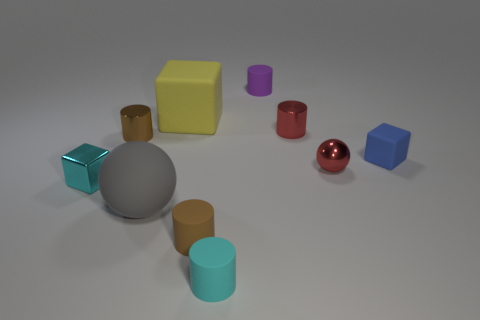

Is the color of the small block that is left of the cyan matte object the same as the small object that is in front of the brown matte thing? 

Predictions:
	answer         	yes
	explanation    	the small block left of the cyan matte cylinder is brown and the small cylinder in front of
	correct_answer 	True


Ann.Answer	yes
Explanation 1	There is a small cyan block that is to the left of the cyan matte cylinder and there is a small cyan cylinder that is in front of the brown matte cylinder.
Explanation 2	There is a small cyan block that is left of the cyan matte cylinder and there is a small cyan cylinder that is in front of the brown matte cylinder.
Explanation 3	The small block on the left side of the cyan matte cylinder is cyan and the small cylinder in front of the brown matte cylinder is cyan.
Explanation 4	There is a small cyan block that is left of the cyan matte cylinder and there is a small cyan cylinder which is in front of the brown matte cylinder.
Explanation 5	The small bl

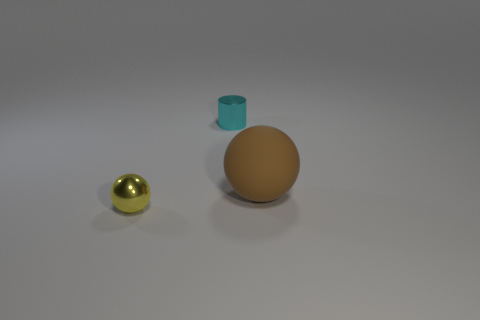

There is a tiny shiny thing that is in front of the brown rubber ball; what is its color? 

Predictions:
	answer         	yellow
	explanation    	the tiny shiny ball in front of the brown rubber ball is yellow
	correct_answer 	True


Ann.Answer	yellow
Explanation 1	There is a tiny yellow shiny ball which is in front of the brown rubber ball.
Explanation 2	There is a tiny yellow shiny sphere that is in front of the brown rubber ball.
Explanation 3	The tiny shiny sphere in front of the brown rubber ball is yellow.
Explanation 4	The tiny shiny ball in front of the brown rubber ball is yellow.


Q 416286 / Image 41629 / CLEVR_train_041629.png



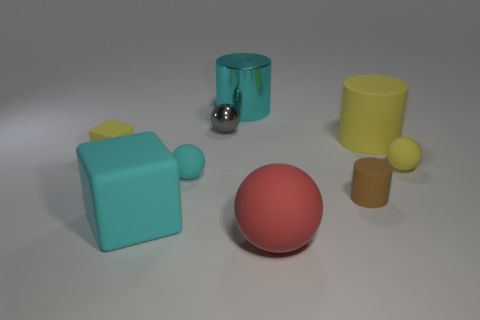

What number of tiny balls have the same color as the big cube? 

Predictions:
	answer         	1
	explanation    	there is the tiny cyan ball that has the same color as a big cube
	correct_answer 	True


Ann.Answer	1
Explanation 1	There is a tiny cyan ball which has the identical color as a big cube.
Explanation 2	There is a tiny cyan ball that has the same color as a big cube.


Q 43283 / Image 4328 / CLEVR_train_004328.png



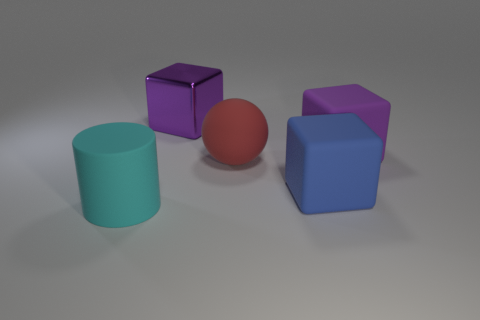

There is a large matte object that is behind the ball; what is its color? 

Predictions:
	answer         	purple
	explanation    	the large matte cube behind the ball is purple
	correct_answer 	True


Ann.Answer	purple
Explanation 1	The large matte cube behind the ball is purple.
Explanation 2	The large matte cube behind a ball is purple.
Explanation 3	There is a large purple matte cube that is behind the ball.
Explanation 4	There is a large purple matte block which is behind the ball.
Explanation 5	The large matte block behind a ball is purple.
Explanation 6	The large matte block behind the ball is purple.


Q 342178 / Image 34218 / CLEVR_train_034218.png



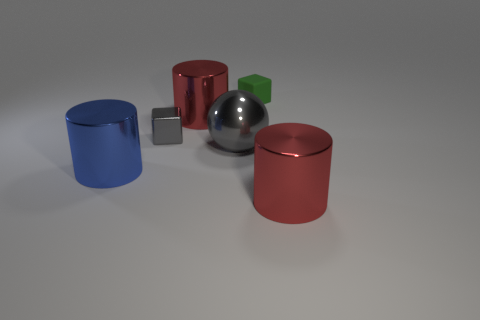

There is a large red shiny object that is behind the red metal cylinder that is in front of the big blue metal cylinder; what number of big metal cylinders are in front of it? 

Predictions:
	answer         	1
	explanation    	there is a big metal cylinder that is in front of the large red shiny cylinder that is
	correct_answer 	False


Ann.Answer	2
Explanation 1	There are two big metal cylinders which are in front of the large red shiny cylinder that is behind the red metal cylinder that is in front of the big blue metal cylinder.
Explanation 2	There are two big metal cylinders that are in front of the large red shiny cylinder that is behind the red metal cylinder that is in front of the big blue metal cylinder.


Q 545651 / Image 54566 / CLEVR_train_054566.png



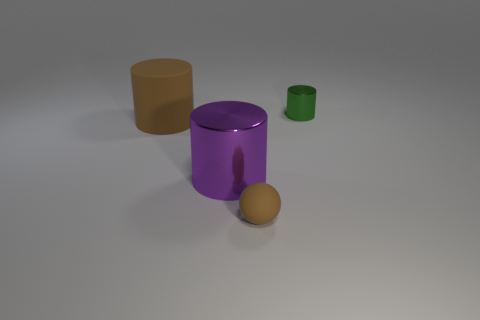

There is a purple shiny object; what shape is it? 

Predictions:
	answer         	cylinder
	explanation    	the purple shiny object is a cylinder
	correct_answer 	True


Ann.Answer	cylinder
Explanation 1	The purple shiny object is a cylinder.
Explanation 2	The purple shiny thing is a cylinder.
Explanation 3	There is a purple shiny cylinder.


Q 376214 / Image 37622 / CLEVR_train_037622.png



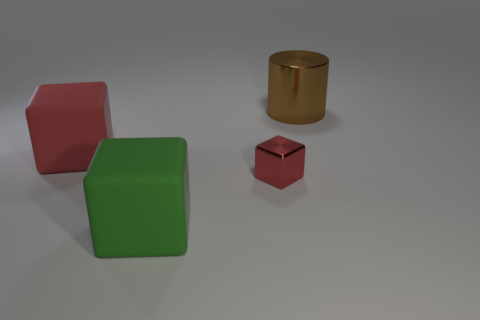

Does the big thing on the right side of the small red thing have the same material as the red block that is on the right side of the big red matte thing? 

Predictions:
	answer         	yes
	explanation    	the big cylinder to the right of the small red cube is shiny and the red block right
	correct_answer 	True


Ann.Answer	yes
Explanation 1	There is a big shiny cylinder which is on the right side of the small red cube and there is a red shiny block which is on the right side of the big red matte cube.
Explanation 2	There is a big metal cylinder that is to the right of the small red cube and there is a red metallic block which is to the right of the big red matte cube.
Explanation 3	The big cylinder on the right side of the small red block is shiny and the red block to the right of the big red matte block is metallic.
Explanation 4	The big cylinder to the right of a small red block is metal and the red block on the right side of a big red matte block is shiny.
Explanation 5	The big cy

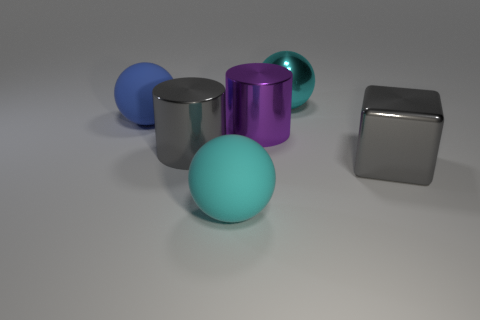

There is a big ball that is both behind the gray block and right of the blue matte thing; what material is it made of? 

Predictions:
	answer         	metal
	explanation    	there is a big metal ball behind the gray block and to the right of the blue matte
	correct_answer 	True


Ann.Answer	metal
Explanation 1	There is a big shiny ball behind the gray block and on the right side of the blue matte ball.
Explanation 2	There is a big metal ball behind the gray block and to the right of the blue matte ball.
Explanation 3	There is a big metallic ball behind the gray block and right of the blue matte sphere.


Q 75164 / Image 7516 / CLEVR_train_007516.png



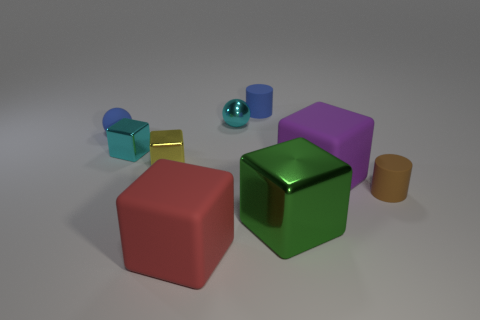

The tiny metal ball has what color? 

Predictions:
	answer         	cyan
	explanation    	there is a tiny cyan metal ball
	correct_answer 	True


Ann.Answer	cyan
Explanation 1	There is a tiny cyan metal ball.
Explanation 2	The tiny metal ball is cyan.


Q 278263 / Image 27827 / CLEVR_train_027827.png



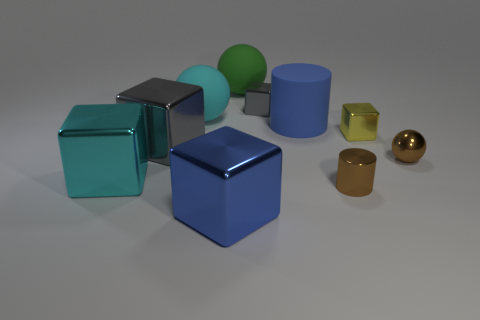

There is a blue object that is behind the gray metallic thing in front of the blue object that is behind the small ball; what shape is it? 

Predictions:
	answer         	cylinder
	explanation    	there is a blue cylinder that is behind the gray metallic cube that is in front of the
	correct_answer 	True


Ann.Answer	cylinder
Explanation 1	There is a blue cylinder that is behind the gray metallic cube that is in front of the blue cylinder that is behind the small ball.
Explanation 2	There is a blue cylinder which is behind the gray metallic cube that is in front of the blue cylinder that is behind the small ball.


Q 58047 / Image 5804 / CLEVR_train_005804.png



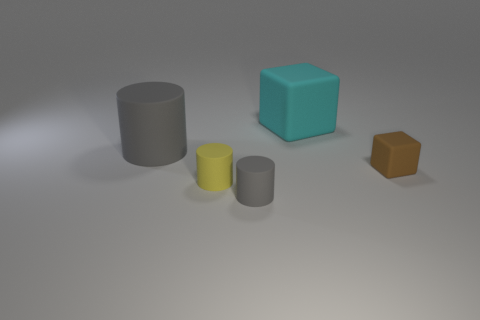

There is a gray thing that is behind the brown thing; does it have the same shape as the big matte object that is right of the small yellow cylinder? 

Predictions:
	answer         	no
	explanation    	the gray object behind the brown cube is a cylinder and the big matte object right of the
	correct_answer 	True


Ann.Answer	no
Explanation 1	The gray thing behind the brown cube is a cylinder and the big matte object on the right side of the small yellow cylinder is a block.
Explanation 2	The gray thing behind a brown cube is a cylinder and the big matte object on the right side of a small yellow cylinder is a block.
Explanation 3	The gray object behind a brown cube is a cylinder and the big matte object on the right side of a small yellow cylinder is a block.
Explanation 4	The gray object behind the brown cube is a cylinder and the big matte object right of the small yellow cylinder is a cube.
Explanation 5	The gray thing behind the brown cube is a cylinder and the big matte object rig

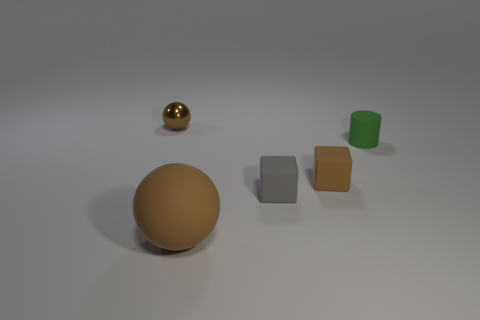

There is a thing behind the tiny cylinder; what is its shape? 

Predictions:
	answer         	sphere
	explanation    	the object behind the tiny cylinder is a ball
	correct_answer 	True


Ann.Answer	sphere
Explanation 1	The object behind the tiny cylinder is a sphere.
Explanation 2	The object behind a tiny cylinder is a ball.
Explanation 3	There is a sphere that is behind the tiny cylinder.
Explanation 4	The thing behind a tiny cylinder is a ball.
Explanation 5	There is a ball which is behind the tiny cylinder.


Q 207103 / Image 20711 / CLEVR_train_020711.png



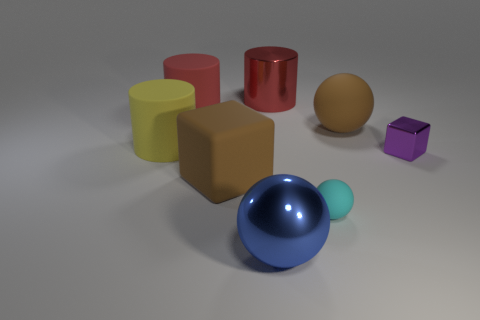

There is a large thing that is on the left side of the big shiny ball and behind the big rubber sphere; what is its shape? 

Predictions:
	answer         	cylinder
	explanation    	there is a large cylinder to the left of the big shiny ball and behind the big rubber
	correct_answer 	True


Ann.Answer	cylinder
Explanation 1	There is a large cylinder on the left side of the big shiny ball and behind the big rubber sphere.
Explanation 2	There is a large cylinder left of the big shiny ball and behind the big rubber sphere.
Explanation 3	There is a large cylinder to the left of the big shiny ball and behind the big rubber sphere.


Q 143713 / Image 14372 / CLEVR_train_014372.png



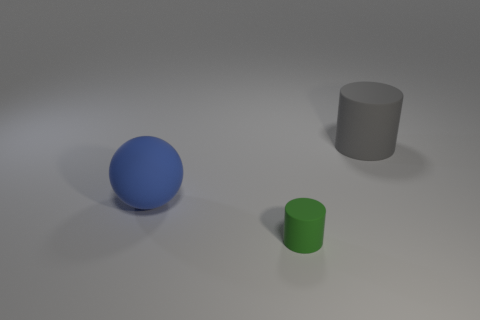

There is a ball; does it have the same color as the cylinder that is to the right of the small green matte object? 

Predictions:
	answer         	no
	explanation    	there is a blue ball and there is a gray cylinder that is right of the small green
	correct_answer 	True


Ann.Answer	no
Explanation 1	The ball is blue and the cylinder right of the small green matte cylinder is gray.
Explanation 2	There is a blue ball and there is a gray cylinder which is to the right of the small green matte cylinder.
Explanation 3	There is a blue ball and there is a gray cylinder which is on the right side of the small green matte cylinder.
Explanation 4	There is a blue ball and there is a gray cylinder that is right of the small green matte cylinder.





In [10]:
examples.sample(20).apply(lambda x: show_example(x), axis=1)
print()

# Success rate and color terms

In [11]:
COLOR_TERMS = ['black', 'white', 'red', 'green', 'yellow', 'blue', 'brown', 'orange', 'pink', 'purple', 'grey', 'gray']
COLOR_CATS = ['color', 'colour']

def contains_color_cat(s):
    q = r'|'.join(COLOR_CATS)
    return True if re.search(q, s, re.IGNORECASE) else False

def contains_color_term(s):
    q = r'|'.join(COLOR_TERMS)
    return True if re.search(q, s, re.IGNORECASE) else False

def get_acc_for_mask(df, mask_series):
    _df = df.loc[mask_series]
    if len(_df) == 0:
        # prevent zero division error
        return -1
    acc = sum(_df.correct_answer) / len(_df)
    return acc

In [12]:
cat_in_q = examples.question.map(contains_color_cat)
cat_in_exp = examples.explanation.map(contains_color_cat)
cat_in_ans = examples.answer.map(contains_color_cat)

term_in_q = examples.question.map(contains_color_term)
term_in_exp = examples.explanation.map(contains_color_term)
term_in_ans = examples.answer.map(contains_color_term)

clr_in_any = cat_in_q | cat_in_exp | cat_in_ans | term_in_q | term_in_exp | term_in_ans

print(f'{"clr_in_any".ljust(11)} : {round(sum(clr_in_any / len(examples)), 2)}')
print(f'{"cat_in_q".ljust(11)} : {round(sum(cat_in_q / len(examples)), 2)}')
print(f'{"cat_in_exp".ljust(11)} : {round(sum(cat_in_exp / len(examples)), 2)}')
print(f'{"cat_in_ans".ljust(11)} : {round(sum(cat_in_ans / len(examples)), 2)}')
print(f'{"term_in_q".ljust(11)} : {round(sum(term_in_q / len(examples)), 2)}')
print(f'{"term_in_exp".ljust(11)} : {round(sum(term_in_exp / len(examples)), 2)}')
print(f'{"term_in_ans".ljust(11)} : {round(sum(term_in_ans / len(examples)), 2)}')

clr_in_any  : 0.9
cat_in_q    : 0.21
cat_in_exp  : 0.08
cat_in_ans  : 0.0
term_in_q   : 0.77
term_in_exp : 0.78
term_in_ans : 0.08


In [13]:
baseline_acc = sum(examples.correct_answer) / len(examples)
clr_in_any_acc = get_acc_for_mask(examples, clr_in_any)
cat_in_q_acc = get_acc_for_mask(examples, cat_in_q)
cat_in_exp_acc = get_acc_for_mask(examples, cat_in_exp)
cat_in_ans_acc = get_acc_for_mask(examples, cat_in_ans)
term_in_q_acc = get_acc_for_mask(examples, term_in_q)
term_in_exp_acc = get_acc_for_mask(examples, term_in_exp)
term_in_ans_acc = get_acc_for_mask(examples, term_in_ans)

print(f'acc {"".ljust(11)} : {round(baseline_acc, 2)}')
print(f'acc {"clr_in_any".ljust(11)} : {round(clr_in_any_acc, 2)}')
print(f'acc {"cat_in_q".ljust(11)} : {round(cat_in_q_acc, 2)}')
print(f'acc {"cat_in_exp".ljust(11)} : {round(cat_in_exp_acc, 2)}')
print(f'acc {"cat_in_ans".ljust(11)} : {round(cat_in_ans_acc, 2)}')
print(f'acc {"term_in_q".ljust(11)} : {round(term_in_q_acc, 2)}')
print(f'acc {"term_in_exp".ljust(11)} : {round(term_in_exp_acc, 2)}')
print(f'acc {"term_in_ans".ljust(11)} : {round(term_in_ans_acc, 2)}')

acc             : 0.83
acc clr_in_any  : 0.83
acc cat_in_q    : 0.8
acc cat_in_exp  : 0.75
acc cat_in_ans  : -1
acc term_in_q   : 0.83
acc term_in_exp : 0.83
acc term_in_ans : 0.88
